# Linear regression with learnable noise parameter

In [40]:
try:
  import optax
except:
  %pip install -qq optax
  import optax
try:
    from ajax import Prior, Likelihood, Variational, ADVI
except:
   %pip install -qq git+https://github.com/patel-zeel/ajax.git
   from ajax import Prior, Likelihood, Variational, ADVI

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
import seaborn as sns

In [41]:
with open("../data/linear_regression/linear_regression",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[ 1.7598495 ],
         [-0.23643708],
         [ 3.1509051 ],
         [-0.79705334],
         [-2.500547  ],
         [ 1.6101036 ],
         [ 0.14806175],
         [ 0.05331182],
         [ 2.6665907 ],
         [-0.14456654]], dtype=float32),
  'y': array([[ 9.011515 ],
         [ 5.4843464],
         [ 9.670069 ],
         [ 1.1274505],
         [-1.283633 ],
         [ 7.062801 ],
         [ 3.6567392],
         [ 2.2533112],
         [10.321623 ],
         [ 2.2750926]], dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32),
  'alpha': 1,
  'beta': 1}}

In [42]:
X = data['data']['x']
Y = data['data']['y'] 
Y = jnp.array(data['data']['y']).reshape((-1))
prior_mean = data['prior']['mean']
prior_cov = data['prior']['var']
prior_alpha = data['prior']['alpha']
prior_beta = data['prior']['beta']

In [43]:
def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = X.shape[0]
X = identity_trans(X)

In [44]:
prior = Prior(
    distributions = {
        "theta" : tfd.MultivariateNormalDiag(loc = prior_mean, scale_diag = jnp.diagonal(prior_cov)),
        "noise" : tfd.InverseGamma(concentration = prior_alpha, scale = prior_beta)
        }
    )

In [45]:
def link_func(samples):
    mean = X@samples["theta"]
    diag = jnp.ones_like(mean)*samples["noise"]
    return {"loc" : mean, "scale_diag" : diag}

In [46]:
likelihood = Likelihood(tfp.distributions.MultivariateNormalDiag, link_func)

In [47]:
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Identity(),"noise":tfb.Exp()},
    vi_type="full_rank"
)

In [48]:
advi = ADVI(prior, likelihood, variational, Y)

In [49]:
params = variational.get_params()
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss),static_argnames=['n_samples'])
seed = jax.random.PRNGKey(10)
value_and_grad_fun(params, seed)

(DeviceArray(43.42201, dtype=float32),
 {'noise': <tfp.distributions.TransformedDistribution 'expMultivariateNormalTriL' batch_shape=[] event_shape=[1] dtype=float32>,
  'theta': <tfp.distributions.TransformedDistribution 'identityMultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>})

In [12]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed,n_samples = 10)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [50]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(5)}
n_itr = 350
carry,loss = jax.lax.scan(update_func, carry,xs = None,length = n_itr)

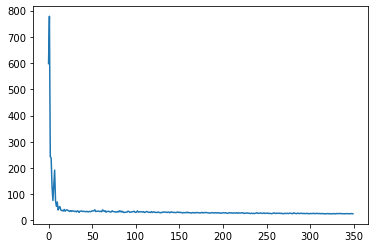

In [51]:
plt.plot(loss)

In [53]:
variational.set_params(carry['params'])
samples = variational.sample(seed = jax.random.PRNGKey(100),sample_shape = (20000,))

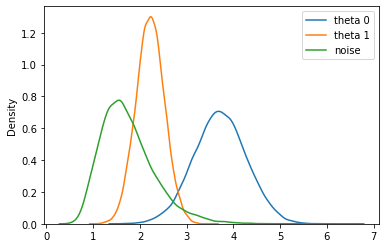

In [54]:
sns.kdeplot(samples['theta'][:,0],label = 'theta 0')
sns.kdeplot(samples['theta'][:,1],label = 'theta 1')
sns.kdeplot(samples['noise'],label = 'noise')
plt.legend()

In [55]:
with open ("../results/linear_regression_noise/results_data/ajax_model","wb") as f:
    pickle.dump(variational,f,protocol=1)